In [22]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numerapi 
import sklearn

In [27]:
temp = pd.read_csv("all.napi", index_col=None)
acct = "graphman"
temp = temp[temp['account']==acct]
public_id = temp.loc[temp['type']=='public', 'value'].values[0]
private_key = temp.loc[temp['type']=='private', 'value'].values[0]

In [36]:
#from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

In [29]:
# some API calls do not require logging in
napi = numerapi.NumerAPI(verbosity="info",
                        public_id=public_id,
                        secret_key=private_key)

In [31]:
data_dir = "./datadir"
cur_round = napi.get_current_round()
data_path = os.path.join(data_dir, "numerai_dataset_"+str(cur_round))
if not os.path.exists(data_path):
    napi.download_current_dataset(dest_path=data_dir, unzip=True)
files = os.listdir(data_path)
fdict = {}
for file in files:
    fpath = os.path.join(data_path, file)
    fsize = os.path.getsize(fpath)
    fdict[file] = [fpath, fsize]
fdict    

{'analysis_and_tips.ipynb': ['./datadir\\numerai_dataset_233\\analysis_and_tips.ipynb',
  234643],
 'example_model.py': ['./datadir\\numerai_dataset_233\\example_model.py',
  8536],
 'example_model.r': ['./datadir\\numerai_dataset_233\\example_model.r', 9280],
 'example_predictions_target_kazutsugi.csv': ['./datadir\\numerai_dataset_233\\example_predictions_target_kazutsugi.csv',
  41464549],
 'numerai_tournament_data.csv': ['./datadir\\numerai_dataset_233\\numerai_tournament_data.csv',
  2621558835],
 'numerai_training_data.csv': ['./datadir\\numerai_dataset_233\\numerai_training_data.csv',
  794941377],
 'numerox_example.py': ['./datadir\\numerai_dataset_233\\numerox_example.py',
  990]}

In [39]:
train = pd.read_csv(fdict['numerai_training_data.csv'][0])

In [40]:
train.columns
x_cols = [c for c in train.columns if c.startswith('feature')]
y_col = train.columns[-1]

In [41]:
#pcr = make_pipeline(StandardScaler(), PCA(n_components=40), LinearRegression())
pls = PLSRegression(n_components=40)
X_train = train.loc[:, x_cols]
y_train = train.loc[:, y_col]
pls.fit(X_train, y_train)
#pcr.fit(X_train, y_train)

PLSRegression(n_components=40)

In [44]:
locals().keys()
train.shape

(501808, 314)

In [9]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=3, max_depth=10)
X_train = train.loc[:, x_cols]
y_train = train.loc[:, y_col]
rfr.fit(X_train, y_train)
#pcr.fit(X_train, y_train)

NameError: name 'x_cols' is not defined

In [8]:
rfr

NameError: name 'rfr' is not defined

In [35]:
del train

In [13]:
test = pd.read_csv(fdict['numerai_tournament_data.csv'][0])

In [14]:
test[x_cols] = test[x_cols].apply(np.float32)

In [15]:
y_pred = pls.predict(test[x_cols])

(array([7.30000e+01, 1.89100e+03, 2.38170e+04, 1.65031e+05, 5.15728e+05,
        6.09406e+05, 2.77874e+05, 5.43110e+04, 5.11600e+03, 2.16000e+02]),
 array([0.40061441, 0.41978684, 0.43895928, 0.45813171, 0.47730414,
        0.49647658, 0.51564901, 0.53482144, 0.55399388, 0.57316631,
        0.59233874]),
 <BarContainer object of 10 artists>)

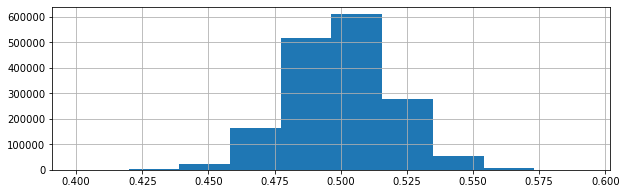

In [16]:
fig, ax = plt.subplots(figsize=(10,3))
ax.grid()
ax.hist(y_pred)
#dir(ax)

In [17]:
min_y = min(y_pred)
max_y = max(y_pred)

mean_y = np.mean(y_pred)
print(min_y, max_y, mean_y)
adj_pred = (y_pred - min_y)/(max_y - min_y)
print(min(adj_pred), max(adj_pred))

[0.40061441] [0.59233874] 0.5000025748537703
[0.] [1.]


(array([7.30000e+01, 1.89100e+03, 2.38170e+04, 1.65031e+05, 5.15728e+05,
        6.09406e+05, 2.77874e+05, 5.43110e+04, 5.11600e+03, 2.16000e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

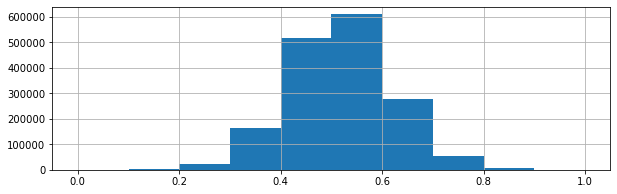

In [18]:
fig, ax = plt.subplots(figsize=(10,3))
ax.grid()
ax.hist(adj_pred)
#dir(ax)

In [19]:
# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = test["id"].to_frame()
predictions_df["prediction_kazutsugi"] = adj_pred
predictions_df.head()
tourn = napi.get_tournaments()
tnum = tourn[0]['tournament']
tfile = f"jhmuller_predictions_{tnum}.csv"
predictions_df.to_csv(tfile, index=False)

In [20]:
napi.upload_predictions(tfile)


2020-10-05 07:45:07,163 INFO numerapi.base_api: uploading predictions...


'68e0599e-cfb9-41c7-9474-ce0c3855203b'

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
ax.grid()
ax.scatter(y_pred, y_valid)
#dir(ax)

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
ax.grid()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
#dir(ax)

In [ ]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=50), LinearRegression())
for last in (range(1,5)):
    X_train = train.loc[train['era'] == "era"+str(last), x_cols]
    y_train = train.loc[train['era'] == "era"+str(last), y_col]
    X_valid = train.loc[train['era'] == "era"+str(last+1), x_cols]
    y_valid = train.loc[train['era'] == "era"+str(last+1), y_col]
    if True:
        pcr.fit(X_train, y_train)
        pca = pcr.named_steps['pca']  # retrieve the PCA step of the pipeline
        y_pred = pcr.predict(X_valid)
        pca_rmse = (np.sum(y_valid - y_pred)**2 / y_valid.shape[0])**0.5
        pca_mad = (np.sum(np.abs(y_valid - y_pred)) / y_valid.shape[0])        
        print(last, pca_mad)
    rfreg = RandomForestRegressor(n_estimators=300, max_depth=40, random_state=0)
    rfreg.fit(X_train, y_train)
    y_pred = rfreg.predict(X_valid)
    rf_rmse = (np.sum(y_valid - y_pred)**2 / y_valid.shape[0])**0.5
    rf_mad = (np.sum(np.abs(y_valid - y_pred)) / y_valid.shape[0])      
    print(last, rf_mad)    